In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # suppress future warnings (about pandas.replace)

# 1. Data Preparation



In [2]:
# load the data
churn = pd.read_csv('churn.csv', sep = ' ')

# convert COLLEGE as numeric
churn['COLLEGE'] = churn['COLLEGE'].replace({'zero':0, 'one':1}) 

# drop 4 categorical variables for simplicity 
churn.drop(columns = ['OVER_15MINS_CALLS_PER_MONTH', 
                      'REPORTED_SATISFACTION', 
                      'REPORTED_USAGE_LEVEL', 
                      'CONSIDERING_CHANGE_OF_PLAN'], 
           inplace = True)

churn.shape

(20000, 8)

**Split and Scale the Data**

In [3]:
X = churn.drop(columns = 'LEAVE')       # features

y = churn['LEAVE']                      # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16000, 7)

(4000, 7)

(16000,)

(4000,)

In [4]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)   

X_test_scaled  = scaler.transform(X_test)

display(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(16000, 7)

(4000, 7)

(16000,)

(4000,)

# 2. Modeling

## 2.1 Baseline Models  

Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) of ``sklearn.dummy.DummyClassifier``. 

- `strategy`:  {“most_frequent”, “prior”, “stratified”, “uniform”, “constant”}, default=”prior”

### 2.1(a) Majority Classifier   

- `strategy` = 'most_frequent': all predicted as 'STAY' and the estimated 'STAY' probabilities are all 100%.
- `strategy` = 'prior':  all predicted as 'STAY' and the estimated 'STAY' probabilities are all 50.58% (the prior).

The predicted classes are the same, the difference is in the estimated class probabilities. 

In [5]:
y_train.value_counts()    # what is the majority class: 'STAY' 

LEAVE
STAY     8093
LEAVE    7907
Name: count, dtype: int64

In [6]:
from sklearn.dummy import DummyClassifier

majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)

pred1 = majority.predict(X_test_scaled)                    # predicted classes
prob1 = majority.predict_proba(X_test_scaled)              # predicted class probabilities
base_rate1 = majority.score(X_test_scaled, y_test)         # test score, same as accuracy_score(y_test, pred1)

print("Accuracy of majority model: {:.2%}".format(base_rate1)) 
print("No. of STAY Predictions:", sum(pred1 == 'STAY'))    # all predicted as "STAY" (the majority class)
print("Estimated class probabilities: \n", prob1)          # Stay probabilities are 1 for all

Accuracy of majority model: 51.38%
No. of STAY Predictions: 4000
Estimated class probabilities: 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### 2.1(b) Random Classifier

- `strategy` = 'uniform'

In [7]:
random = DummyClassifier(strategy = 'uniform', random_state = 0).fit(X_train_scaled, y_train)

pred2 = random.predict(X_test_scaled)
prob2 = random.predict_proba(X_test_scaled)
base_rate2 = random.score(X_test_scaled, y_test)                  

print("Accuracy of random model: {:.2%}".format(base_rate2))   
print("No. of LEAVE Predictions:", sum(pred2 == 'LEAVE'))   # almost 50% predicted as LEAVE 
print("Estimated class probabilities: \n", prob2)           # same estimated class probability for both classes  

Accuracy of random model: 49.53%
No. of LEAVE Predictions: 1960
Estimated class probabilities: 
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 ...
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


## 2.2 Two Good Models


Let's train two models and use the default threshold (0.5) for class prediction and evaluation.

### 2.2(a) Linear SVC

Here we use the ``LinearSVC`` function (check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for details) as the ``SVC`` function takes a longer training time with a large dataset.   

In [8]:
svm = LinearSVC()                # default C=1.0

svm.fit(X_train_scaled,y_train)    

svm.score(X_test_scaled,y_test)  # check plain accuracy

0.6425

### 2.2(b) Decision Tree

In [9]:
# arbitary hyparameter setting for tree as well

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5,  min_samples_leaf = 500, random_state = 1)    

tree.fit(X_train_scaled, y_train)

tree.score(X_test_scaled,y_test)   # check plain accuracy

0.7085

# 3. Model Evaluation


## 3.1 Confusion Matrix 

Use ``sklearn.metrics.confusion_matrix`` function to compute the confusion matrix. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for details.

- ``normalize``: {‘true’, ‘pred’, ‘all’}, `default = None`.

### 3.1(a) Linear SVC

**Confusion Matrix**

In [10]:
from sklearn.metrics import confusion_matrix

svm_pred = svm.predict(X_test_scaled)                   # obtained predicted classes first

cm = confusion_matrix(y_true = y_test, y_pred = svm_pred)   

cm    # rows are actual labels, cols are predicted labels 

array([[1220,  725],
       [ 705, 1350]])

**Visualize the confusion matrix as a heatmap**

- With a confusion matrix, use `sklearn.metrics.ConfusionMatrixDisplay` class (check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)) for visualization.

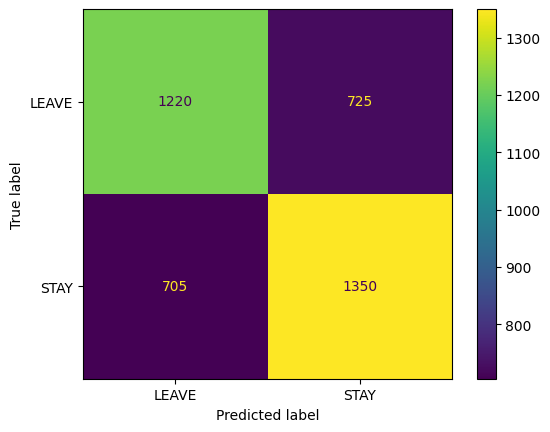

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm.classes_)

disp.plot()   # additional parameters can be added here

plt.show() 

**The following approaches are recommended as as more convient alternatives.**


- Use `ConfusionMatrixDisplay.from_estimator` method to plot a confusion matrix given an estimator and data. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_estimator) for details.


```python
ConfusionMatrixDisplay.from_estimator(estimator = svm,  X = X_test_scaled, y = y_test)
plt.show()
```




- Use `ConfusionMatrixDisplay.from_predictions` method to plot a confusion matrix given the true and predicted labels. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) for details.

```python
ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = svm_pred)
plt.show()
```

### 3.1(b) Decision Tree

<font color=red>***Exercise 1: Your Codes Here***</font>  

Please visualize the tree model's performance on test data using confusion matrix.  

Confusion matrix:
 [[1374  571]
 [ 595 1460]]


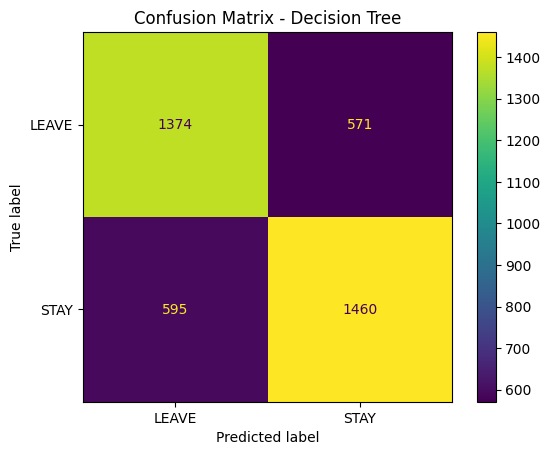

In [14]:
# Decision Tree performance on test set (confusion matrix)
tree_pred = tree.predict(X_test_scaled)

cm_tree = confusion_matrix(y_test, tree_pred)
print("Confusion matrix:\n", cm_tree)

# visualize
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=tree_pred, display_labels=tree.classes_)
plt.title('Confusion Matrix - Decision Tree')
plt.show()

## 3.2 Evaluation Metrics

In a binary classification task: 
- **Accuracy** = TP + TN / (TP + TN + FP + FN). Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for the ``accuracy_score`` function.
- **Sensitivity (Recall)** = TP / (TP + FN), also called **TP rate**. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) for the ``recall_score`` function.
- **Precision** = TP / (TP + FP). Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) for the ``precision_score`` function.
- **F1 Score** = 2 * Precision * Recall / (Precision + Recall). Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) for the ``f1_score`` function.



For ``recall_score``, ``precision_score`` and ``f1_score`` functions, pay attention to the following parameters: 

- ``pos_label``: the class to report (str or int, ``default``= 1). If classes are not {-1, 1} or {0, 1}, then ``pos_label`` should be explicitly given (e.g., 'LEAVE').

  For multi-class data, this parameter will be ignored.

      

- ``average``:  `default` = 'binary', which reports results for the class set by `pos_label` (only applicable for binary target).

  For multi-class data, the parameter takes the following options:

  -  `'macro'`: calculate metrics for each class and take the average (equal weight for each class). In binary-class tasks, ``macro_recall`` = (TP/(TP+FN) + TN/(TN+FP))/2; ``macro_precision`` = (TP/(TP+FP) + TN/(TN+FN))/2.

  - `'micro'`: calculate metrics globally (each weight for each instance). Same as accuracy for single-label classification, but different in multi-label tasks. 

  - `'weighted'`: calculate metrics for each class, and find their average weighted by `support` (the number of true instances for each class).

  - `None`: the scores for each class are returned.
    
There is no function for **specificity** (i.e., TN rate), why?  

### 3.2(a) Linear SVC

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, svm_pred)                        # same as svm.score(X_test_scaled, y_test) 
recall = recall_score(y_test, svm_pred, pos_label = 'LEAVE')       # specify positive label
precision = precision_score(y_test, svm_pred, pos_label = 'LEAVE')
f1 = f1_score(y_test, svm_pred, pos_label = 'LEAVE') 

print('Accuracy(SVM): {:.2%}'.format(accuracy))                   
print('Recall(SVM): {:.2%}'.format(recall))   
print('Precision(SVM): {:.2%}'.format(precision))    
print('F1(SVM): {:.2%}'.format(f1))

Alternatively, use `classification_report` function (check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for details) to report all metrics for all classes. 

- The `support` column shows the number of instances (from each actual class).
- The `macro avg` take average of the metrics for all classes. 
- The `weighted avg` is the sum of `support`-weighted metrics for all classes.
- The `micro avg` is only shown for multi-label or multi-class with a subset of classes, as it is equal as accuracy otherwise (same for all metrics). 

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true = y_test, y_pred = svm_pred, digits = 4)  # return text  

print(report)   # print text for a readable format

### 3.2(b) Decision Tree

Please compute the accuracy, recall, precision and f1 score for the Tree model.  

<font color=red>***Exercise 2: Your Codes Here***</font>  

# 4. Hyperparameter Tuning 

With different business goals, we may use different evaluation metrics in hyperparameter tuning. Pay attention to the following parameter in `GridSearchCV` :  

- `scoring`: the evaluation metric(s) used to compare parameters/models in cross-validatation. `Default` = None, which use `'accuracy'` for classification models. It takes a single string (or a callable,list, tuple or dict), which can be  `'accuracy'`,  `'precision'`, `'recall'`, `'f1'`, etcs. Check [this link](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for available values.

Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for details

**GridSearchCV for Tree with Different Metrics**   

- If non-accuracy metrics are used, it is important to convert target as numbers so the positive is numerically bigger. 

In [ ]:
# Step 1:  STAY as 0, LEAVE as 1

y_train = y_train.replace({'LEAVE':1, 'STAY':0})

y_test = y_test.replace({'LEAVE':1, 'STAY':0})   

In [ ]:
# Step 2: GridSearchCV, use `recall` in parameter evaluation 

from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)   # define the model

param_range = {'max_depth': [2, 3, 4, 5, 6],  'min_samples_leaf':[100, 200, 300, 400, 500]}   

grid1 = GridSearchCV(estimator = model, 
                     param_grid = param_range, 
                     cv = 5, 
                     scoring = 'recall')    # recall: target as many responders (leaving customers) as possible                    

grid1.fit(X_train_scaled, y_train)        

print("Best params: ", grid1.best_params_)    
print("Mean cv score (recall) for the best params: {:.2%}".format(grid1.best_score_))      

In the search process, a best model (with best params found in the cross-validation) was refitted on the entire dataset automatically. 

- Let's visualize the best model here.

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(28,18))    

best1 = grid1.best_estimator_                    # get the best model refitted on the entire training set

plot_tree(decision_tree = best1, 
          feature_names = X_train.columns,       # or X_train.columns.to_list() if with an old version of scikit-learn
          class_names = ['Stay','Leave'],        # predict class labels corresponding to the labels (0,1)  
          filled = True,                         # if True, paint nodes to indicate majority class  
          fontsize = 8)    

fig.suptitle('Best Tree Model')
plt.show()

<font color=red>***Exercise 3: Your Codes Here***</font>  

Could you please find the best tree size according to **precision**?  
- Please also set `criterion` = 'entropy' and `random_state` = 1 when defining the tree model.
- Name the gridsearch object as `grid2`, search over the same parameter range as above.
- Evaluate the generalization performance of best model (`best2`) on test set.  Try both `grid2.score` and `best2.score` respectively. 